# Нейронная сеть, которая решает задачу регрессии

Задача регрессии -- это предсказание некоторого вещественного числа.

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)

# Train dataset

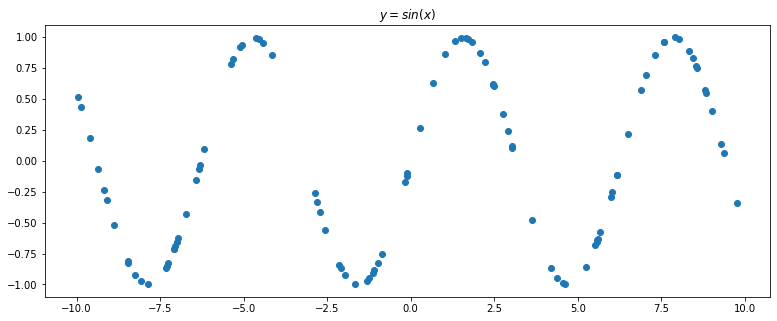

In [3]:
x_train = torch.rand(100)
x_train = x_train * 20 - 10

y_train = torch.sin(x_train)

plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('$y = sin(x)$');

- шум

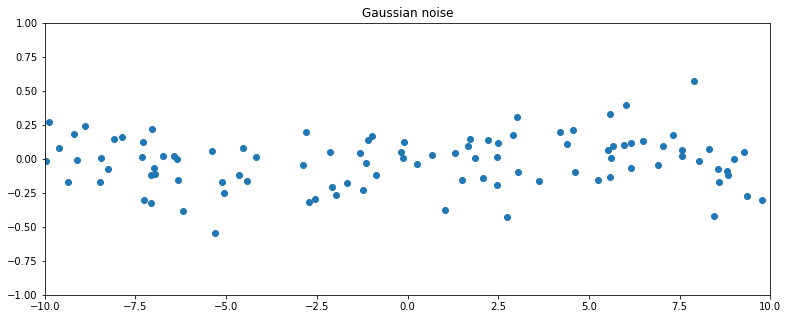

In [4]:
noise = torch.randn(y_train.shape) / 5.

plt.plot(x_train.numpy(), noise.numpy(), 'o')
plt.axis([-10, 10, -1, 1])
plt.title('Gaussian noise');

- зашумленные данные

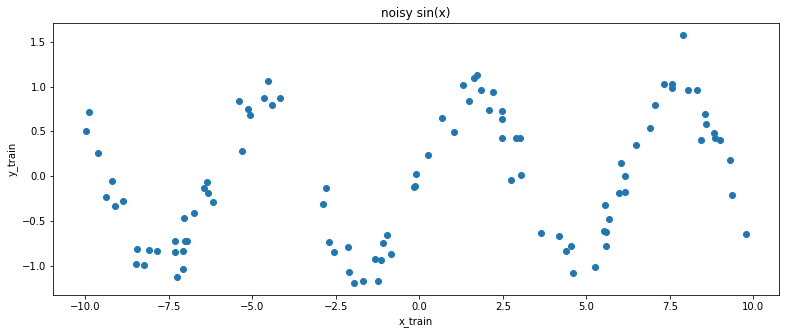

In [5]:
y_train = y_train + noise
plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('noisy sin(x)')
plt.xlabel('x_train')
plt.ylabel('y_train');

Для общности, нам нужно наш вектор X (который сейчас строчка), превратить в столбец, у которого в каждой строчке будет одно число X

- `torch.unsqueeze(input, dim)` - Returns a new tensor with a dimension of size one inserted at the specified position
- `dim` - номер размерности куда вставить одномерный вектор (0 - сделать строку [[....]], 1 - сделать столбец)


Мы применили метод unsqueeze_, так как хотим, чтобы каждый элемент был вектором (пусть и из одного числа)

In [6]:
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)
pass

In [7]:
tmp = torch.Tensor([1,2,3])
print(tmp)
print(tmp.unsqueeze(1))

tensor([1., 2., 3.])
tensor([[1.],
        [2.],
        [3.]])


# Validation dataset

- пусть, например, вообще без шума, хотя так не бывает

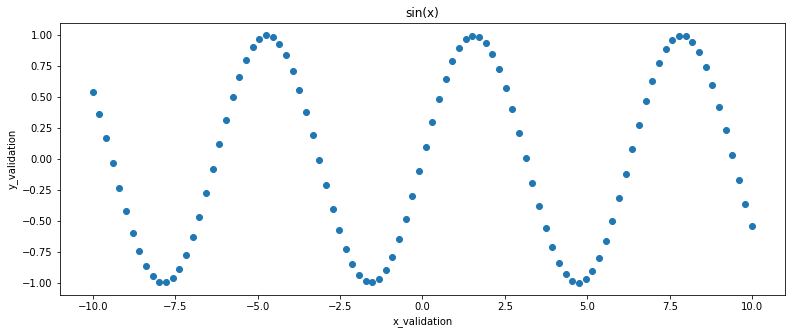

In [8]:
x_validation = torch.linspace(-10, 10, 100)
y_validation = torch.sin(x_validation.data)
plt.plot(x_validation.numpy(), y_validation.numpy(), 'o')
plt.title('sin(x)')
plt.xlabel('x_validation')
plt.ylabel('y_validation');

In [9]:
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1);

# Model construction

Можно описать так:
- два полносязных слоя 1->N и N->1
- между ними функция активации

`fc1` `fc2` - fully connected

`fc1`:
- **Входных нейронов** у нас будет 
  - То есть это, на самом деле, не нейрон будет, а сам вход в нейрон. Это одно число "x", координата нашей точки, по которой мы будем что-то предсказывать
- **Выходных нейронов**, у нас будет `n_hidden_neurons`

`fc2`:
- На выходе ещё один полносвязанный слой, но у него будет всего один выходной нейрон (ответ)

In [10]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sine_net = SineNet(10)

# Prediction

- что дает необученная сеть
  - случайная комбинация `n_hidden_neurons` штук активационных функций

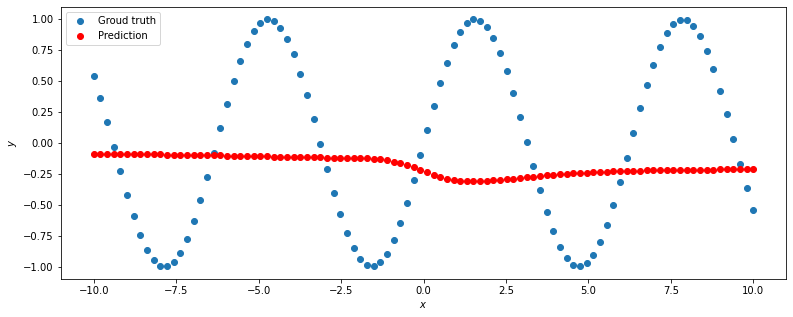

In [11]:
def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(sine_net, x_validation, y_validation)

# Optimizer

- на вход оптимизатору подаются параметры, которые изменяет оптимайзер

Отличия Адама (Adaptive Moment Estimation) - «метод адаптивной оценки моментов»:
- шаг обучения подбирается для каждого параметра (как функция от основного шага)
  - идея заключается в делении скорости обучения для весов на скользящие средние значения недавних градиентов для этого веса (матожидания - первые моменты )(RMSProp - Root Mean Square Propagation)
  - кроме того учитываются вторые моменты градиентов (дисперсии)

In [12]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01)

# Loss function

- MSE

In [13]:
def loss(pred, target):
    squares = (pred - target) ** 2
    return squares.mean()

# Training procedure

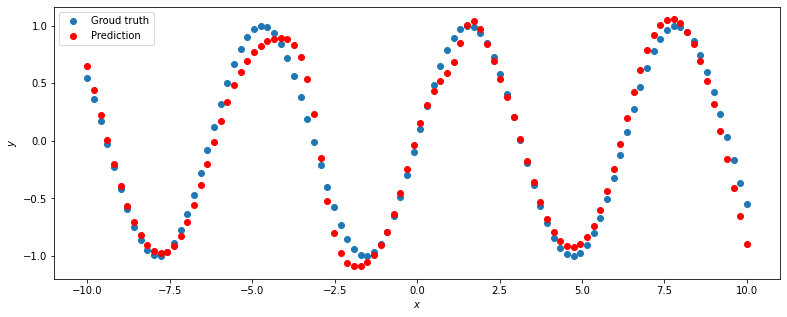

In [14]:
for epoch_index in range(2000):             # эпоха
    optimizer.zero_grad()                   # можно и в конце, но чтоб не забыть, лучше в начале

    y_pred = sine_net.forward(x_train)      #
    loss_val = loss(y_pred, y_train)        # потери (скаляр)

    loss_val.backward()                     # считаем градиенты по параметрам

    optimizer.step()                        # шаг обучения

predict(sine_net, x_validation, y_validation)

Получили линейную комбинацию активационных функций, которая хорошо приближает зависимость

# Более сложная функция

Возьмем более сложную функцию в качестве таргета: $y=2^x sin(2^{-x})$


Кроме того, мы хотим получить хорошую метрику MAE на валидации: ${MAE} = {\frac {1}{l}}\sum _{i=1}^{l}{|y\_pred_{i}-{y\_target_{i}}|}$, тогда как знакомая нам MSE выглядит как ${MSE} = {\frac {1}{l}}\sum _{i=1}^{l}(y\_pred_{i}-{y\_target_{i}})^{2}$

**Задача**: MAE на валидации не хуже 0.03

In [84]:
def target_function(x):
    return 2**x * torch.sin(2**-x)

class RegressionNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

net = RegressionNet(30)     # минимум +/- столько

In [80]:
# ------Dataset preparation start--------:
x_train =  torch.linspace(-10, 5, 100)
y_train = target_function(x_train)
noise = torch.randn(y_train.shape) / 20.
y_train = y_train + noise
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

x_validation = torch.linspace(-10, 5, 100)
y_validation = target_function(x_validation)
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1)
# ------Dataset preparation end--------:
pass

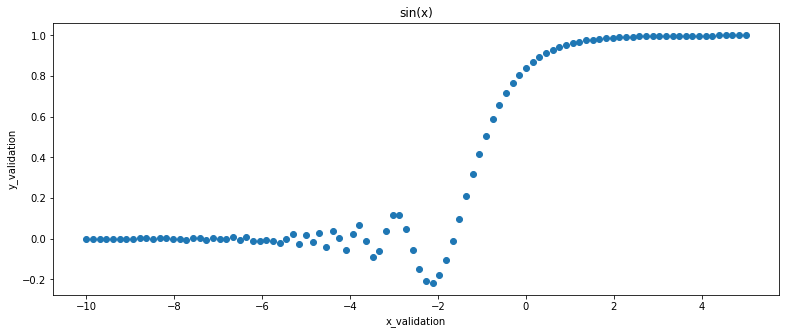

In [81]:
plt.plot(x_validation.numpy(), y_validation.numpy(), 'o')
plt.title('sin(x)')
plt.xlabel('x_validation')
plt.ylabel('y_validation');

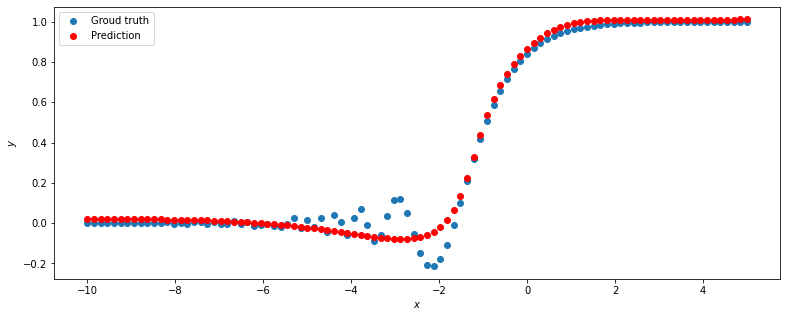

In [82]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

def loss(pred, target):
    diff = torch.abs(pred - target)
    return diff.mean()

for epoch_index in range(1000):
    optimizer.zero_grad()
    
    y_pred = net.forward(x_train)
    loss_val = loss(y_pred, y_train)        # потери (скаляр)

    loss_val.backward()                     # считаем градиенты по параметрам

    optimizer.step()                        # шаг обучения

predict(net, x_validation, y_validation)

In [83]:
# Проверка
def metric(pred, target):
   return (pred - target).abs().mean()

print(metric(net.forward(x_validation), y_validation).item())

0.03282354027032852
